In [3]:
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
from time import perf_counter 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /Users/kristian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [49]:
train = pd.read_csv('data/all/train_prepro.csv')
test = pd.read_csv('data/all/dev_prepro.csv')
train.columns = ['text', 'variety', 'group']
test.columns = ['text', 'variety', 'group']
sets = [train, test]

print(train.group.value_counts())
print(test.group.value_counts())

train.head()

group
bks    55989
es     54209
pt     37713
GER    14279
Name: count, dtype: int64
group
bks    5916
es     5747
GER    4530
pt     3923
Name: count, dtype: int64


,text,variety,group
0,miliona maloljetnih djevojčica prisilno stupi...,bs,bks
1,nakon ovih kalkulacija ubrzo je postalo jasno...,bs,bks
2,u okviru programa modul memorije internacional...,bs,bks
3,sagrađen je po istom principu kao i slični gra...,bs,bks
4,kontroverzni biznismen naser kelmendi koji se ...,bs,bks


/var/folders/8v/5_c7kn_13jsgmgqz56r3yx440000gp/T/ipykernel_44842/2714936594.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train.text.str.len(), bins=100, kde=True, rug=False)
/Users/kristian/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kristian/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN b

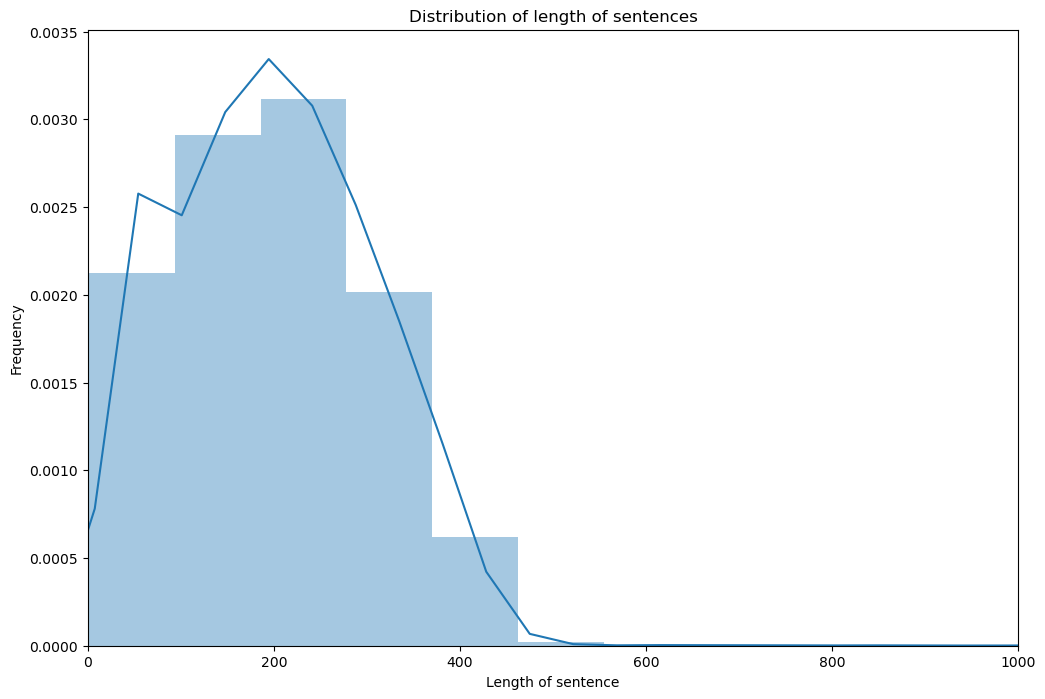

In [66]:
plt.figure(figsize=(12,8))
sns.distplot(train.text.str.len(), bins=100, kde=True, rug=False)
plt.xlim(0,1000)
plt.xlabel('Length of sentence')
plt.ylabel('Frequency')
plt.title('Distribution of length of sentences')
plt.show()


In [69]:
quantile = 0.99
max_len = int(np.quantile(train.text.str.len(), quantile))
print(f'99% of sentences have length <= {max_len}')


99% of sentences have length <= 436


In [50]:
## Encoding the target "group"
le_group = LabelEncoder()

for set in sets:
    set['group_encoded'] = le_group.fit_transform(set['group'])
    

In [4]:
def evaluate_and_plot(model, X, y_true, title):
    """
    Function to evaluate a model and plot a confusion matrix.

    Parameters
    ----------
    model : sklearn model
        Model to evaluate.
    X : array-like
        Features.
    y_true : array-like
        True labels.
    title : str
        Title of the plot.

    Returns
    -------
    None.
    """

    y_pred = model.predict(X)

    # Compute F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {title}\nF1 Score: {f1:.4f}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Generate and print classification report
    report = classification_report(y_true, y_pred)
    print(f"Classification Report - {title}:\n{report}")

In [53]:

train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)

#TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_data['text'])
y_train_group = train_data['group_encoded']
X_val = tfidf_vectorizer.transform(val_data['text'])
X_test = tfidf_vectorizer.transform(test['text'])

#SVM with linear kernel, linearSVC is choosen for effieciency reasons 
classifier_group = LinearSVC()
classifier_group.fit(X_train, y_train_group)

y_val_group_pred = classifier_group.predict(X_val)
y_test_group_pred = classifier_group.predict(X_test)

#Reports
conf_matrix_test_group = confusion_matrix(test['group_encoded'], y_test_group_pred)
class_report_test_group = classification_report(test['group_encoded'], y_test_group_pred)

print("\nConfusion Matrix (Test Set - Group Classification):")
print(conf_matrix_test_group)

print("\nClassification Report (Test Set - Group Classification):")
print(class_report_test_group)

# Step 6: Filter the data for the identified group and proceed to the second classifier
# Assuming 'selected_group' is the group identified by the first classifier
selected_group = 0  # Replace with the actual group identified
selected_group_data = train_data[train_data['group_encoded'] == selected_group]

# Encode the variety within the selected group
label_encoder_variety = LabelEncoder()
selected_group_data['variety_encoded'] = label_encoder_variety.fit_transform(selected_group_data['variety'])
train_data_variety, val_data_variety = train_test_split(selected_group_data, test_size=0.2, random_state=42)

#TF-IDF Vectorization for the second classifier
X_train_variety = tfidf_vectorizer.fit_transform(train_data_variety['text'])
y_train_variety = train_data_variety['variety_encoded']

X_val_variety = tfidf_vectorizer.transform(val_data_variety['text'])

classifier_variety = LogisticRegression()
classifier_variety.fit(X_train_variety, y_train_variety)

y_val_variety_pred = classifier_variety.predict(X_val_variety)

# Evaluate the second classifier
conf_matrix_val_variety = confusion_matrix(val_data_variety['variety_encoded'], y_val_variety_pred)
class_report_val_variety = classification_report(val_data_variety['variety_encoded'], y_val_variety_pred)

print("\nConfusion Matrix (Validation Set - Variety Classification):")
print(conf_matrix_val_variety)

print("\nClassification Report (Validation Set - Variety Classification):")
print(class_report_val_variety)

/Users/kristian/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/8v/5_c7kn_13jsgmgqz56r3yx440000gp/T/ipykernel_44842/2073866619.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_group_data['variety_encoded'] = label_encoder_variety.fit_transform(selected_group_data['var

Confusion Matrix (Validation Set - Group Classification):
[[ 2846     7    17    13]
 [   62 11069    10     8]
 [   42     5 10737    19]
 [   28     8    26  7541]]

Classification Report (Validation Set - Group Classification):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2883
           1       1.00      0.99      1.00     11149
           2       1.00      0.99      0.99     10803
           3       0.99      0.99      0.99      7603

    accuracy                           0.99     32438
   macro avg       0.99      0.99      0.99     32438
weighted avg       0.99      0.99      0.99     32438


Confusion Matrix (Test Set - Group Classification):
[[4470    4   30   26]
 [  32 5880    2    2]
 [  20    6 5714    7]
 [  20    2   14 3887]]

Classification Report (Test Set - Group Classification):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4530
           1       1.

/Users/kristian/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
import random 
def visualize_results(model, X, y_true, text_data, num_samples=15):
    num_samples = min(num_samples, X.shape[0])  
    random_samples = random.sample(range(X.shape[0]), num_samples)

    for idx in random_samples:
        input_text = text_data.iloc[idx]
        true_label = y_true.iloc[idx]

        # Make a prediction
        if hasattr(model, 'predict_proba'):
            # For classifiers that support probability predictions
            prob_scores = model.predict_proba(X[idx])
            predicted_label = model.predict(X[idx])[0]
        else:
            # For classifiers that do not support probability predictions
            predicted_label = model.predict(X[idx])

        print(f"Input Text:\n{input_text}")
        print(f"\nTrue Label: {true_label}")
        print(f"Predicted Label: {predicted_label}")

        if hasattr(model, 'predict_proba'):
            print(f"Predicted Probabilities:\n{prob_scores}")

        print("\n" + "="*50 + "\n")

In [55]:
visualize_results(classifier_group, X_val, val_data['group_encoded'], val_data['text'], num_samples=10)

# Visualize results for the second classifier (variety)
selected_group_data = train_data[train_data['group_encoded'] == selected_group]
selected_group_data['variety_encoded'] = label_encoder_variety.transform(selected_group_data['variety'])
X_val_variety = tfidf_vectorizer.transform(val_data_variety['text'])
visualize_results(classifier_variety, X_val_variety, val_data_variety['variety_encoded'], val_data_variety['text'])

Input Text:
césar rico ruiz dirigente de los populares burgaleses manifestó de manera tajante que «en el pp de castilla y león nadie piensa en otro candidato a la junta que no sea juan vicente herrera ni tampoco en otro presidente de la junta que no sea él porque ha hecho una magnífica gestión y nos lo merecemos»

True Label: 2
Predicted Label: 2
Predicted Probabilities:
[[1.02566443e-04 1.41952499e-05 9.99730977e-01 1.52261210e-04]]


Input Text:
la ministra de seguridad nilda garré ratificó que el gobierno nacional retirará desde mañana a la policía federal de la custodia de los subtes y aseveró que es la autoridad porteña la que debe garantizar la seguridad en ese transporte público

True Label: 2
Predicted Label: 2
Predicted Probabilities:
[[9.15117326e-06 7.51652866e-06 9.99958255e-01 2.50776550e-05]]


Input Text:
 određena suma novca koja najvjerovatnije potiče od preprodaje droge

True Label: 1
Predicted Label: 1
Predicted Probabilities:
[[0.0321545  0.92935017 0.02295994 0.015

/var/folders/8v/5_c7kn_13jsgmgqz56r3yx440000gp/T/ipykernel_44842/1350785826.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_group_data['variety_encoded'] = label_encoder_variety.transform(selected_group_data['variety'])


## Predicting the dialect immediately without the group

Similar to before we use td-idf + classifier for our multi-label classification. This time we exclude our extracted "group" variable and proceed to classify the dialect/variety/language based purely on the input text. 

The approach is the same as before.

In [11]:
variety_train = pd.read_csv('dialect-identification/data/all/train_prepro.csv')
variety_test = pd.read_csv('dialect-identification/data/all/test_prepro.csv')

variety_train.columns = ['text', 'variety', 'group']
variety_test.columns = ['text', 'variety', 'group']
variety_train = variety_train.drop(columns=['group'])
variety_test = variety_test.drop(columns=['group'])

variety_sets = [variety_train, variety_test]

l_enc = LabelEncoder()

for set in variety_sets:
    set['variety_encoded'] = l_enc.fit_transform(set['variety'])

variety_train.variety_encoded.value_counts()

variety_encoded
6     18922
9     18859
10    18854
8     18754
11    18723
5     18564
4     18512
7     16723
3      3870
0      3750
2      3390
1      3269
Name: count, dtype: int64

In [12]:
train_data, val_data = train_test_split(variety_train, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=15000)
X_train = tfidf_vectorizer.fit_transform(train_data['text'])
y_train_group = train_data['variety_encoded']

X_val = tfidf_vectorizer.transform(val_data['text'])
X_test = tfidf_vectorizer.transform(variety_test['text'])

classifier_group = LinearSVC()
classifier_group.fit(X_train, y_train_group)

y_val_group_pred = classifier_group.predict(X_val)
y_test_group_pred = classifier_group.predict(X_test)

conf_matrix_val_group = confusion_matrix(val_data['variety_encoded'], y_val_group_pred)
class_report_val_group = classification_report(val_data['variety_encoded'], y_val_group_pred)

conf_matrix_test_group = confusion_matrix(variety_test['variety_encoded'], y_test_group_pred)
class_report_test_group = classification_report(variety_test['variety_encoded'], y_test_group_pred)

print("Confusion Matrix (Validation Set - Group Classification):")
print(conf_matrix_val_group)

print("\nClassification Report (Validation Set - Group Classification):")
print(class_report_val_group)

print("\nConfusion Matrix (Test Set - Group Classification):")
print(conf_matrix_test_group)

print("\nClassification Report (Test Set - Group Classification):")
print(class_report_test_group)

/Users/kristian/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Confusion Matrix (Validation Set - Group Classification):
[[ 573   59   40   62    3    1    3   37    1    0    2    2]
 [  53  415   43   90    0    1    2   28    1    1    0    0]
 [  88   78  385   94    0    0    1   22    0    1    0    3]
 [  70   42   38  604    0    0    0   38    1    1    0    0]
 [   0    0    1    0 2409    1    2   15  634    3    1  551]
 [   0    0    0    0    0 2991  341  369    1    6    2    0]
 [   0    0    0    0    0  311 3026  367    1    8   15    2]
 [   3    0    1    0    1  329  346 2673    1    4    5    0]
 [   0    0    0    0  591    0    1   14 3001    4    2  156]
 [   2    1    0    1    3    8    2   15    1 3354  378    1]
 [   1    0    0    0    5    2    3   16    1  423 3385    1]
 [   1    1    0    0  498    0    0   14  148    2    2 3097]]

Classification Report (Validation Set - Group Classification):
              precision    recall  f1-score   support

           0       0.72      0.73      0.73       783
           1